In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir('../notebook_format')
from formats import load_style
load_style()

In [2]:
os.chdir(path)
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8, 6 # change default figure size

# 1. magic to print version
# 2. magic so that the notebook will reload external python modules
%load_ext watermark
%load_ext autoreload 
%autoreload 2

# for installing pymc (if you're using anaconda)
# conda install -c https://conda.binstar.org/pymc pymc
import pymc as pm
import scipy.stats as stats
from pymc.Matplot import plot as mcplot

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,matplotlib,pymc,scipy

Ethen 2016-08-03 23:28:44 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1
pymc 2.3.6
scipy 0.18.0


# A/B Testing with Hierarchical Models

Though A/B testing seems simple in that you're just comparing A against B and see which one performs better, but figuring out whether your results mean anything is actually quite complicated. During this explore and evaluate process, failing to correct for multiple comparisons is one of the most common A/B testing mistakes. Hierarchical models are one way to address this problem.

## Background Information

Imagine the following scenario: You work for a company that gets most of its online traffic through ads. Your current ads have a 3% click rate, and your boss decides that's not good enough. The marketing team comes up with 26 new ad designs, and as the company's data scientist, it's your job to determine if any of these new ads have a higher click rate than the current ad.

You set up an online experiment where internet users are shown one of the 27 possible ads (the current ad or one of the 26 new designs). After two weeks, you collect the data on each ad: How many users saw it, and how many times it was clicked on.

Time to run some statistical tests! New design A vs current design? No statistically significant difference. New design B vs current design? No statistically significant difference. You keep running test and continue getting not significant results. Just as you are about lose hope, new design Z v. current design.... Statically significant difference at the alpha = 0.05 level!

You tell your boss you've found a design that has a higher click rate than the current design, and your company deploys it in production. However, after two months of collecting statistics on the new design, it seems the new design has a click rate of 3%. What went wrong?

When performing A/B testing, data scientists often fall into the common pitfall of failing to correct to for multiple testing. Testing at alpha = 0.05 means your statistical test yielding a result as extreme or more extreme by random chance (assuming a given null hypothesis is true) occurs with probability 0.05, or you can say that your statistical test has an EXPECTED 5% false positive rate. If you run 26 statistical tests, then an upper bound on the expected number of false positives is 26*0.05 = 1.3. This means in our above scenario, our data scientist can expect to have at least one false positive result, and unfortunately, the false positive result is the one she reported to her boss.

## Preliminary Statistics

There are two well-known branches of statistics: Frequentist statistics and Bayesian statistics. These two branches have plenty of differences, but we're going to focus on one key difference:

- In frequentist statistics, we assume the parameter(s) of interest are fixed constants. We focus on computing the likelihood $p(Data \mid Parameter)$, the probability we see the observed set of data points given the parameter of interest.
- In Bayesian statistics, we having uncertainty surrounding our parameter(s) of interest, and we mathematically capture our prior uncertainty about these parameters in a prior distribution, formally represented as $p(Parameter)$. We focus on computing the posterior distribution $p(Parameter \mid Data)$, representing our posterior uncertainty surrounding the parameter of interest after we have observed data.

Put it in another way, when using frequentist statistics, you based your decision on whether A beat B only from the data in the test all other information is irrelevant as you are simply testing A against B. And nothing else is relevant, much like justice should be blind to outside beliefs.

On the other hand, the Bayesian approach lets you to think a bit deeper about the problem.When you're testing A against B you actually do have some other information. You know what makes sense. And this is valuable information when making a decision. So, sure, justice may be blind - but sometimes we need her to peek a bit and make sure what's on the scale makes sense!

For A/B testing, what this means is that you, the marketer, have to come up with what conversion rate *makes sense*, known as the prior. That is, if you typically see a 10% conversion in A, you would not, during the test, expect to see it at 100%.

Then instead of only finding the winner in the test itself, Bayesian analysis will include your prior knowledge into the test. That is, you can tell the test what you believe the right answer to be - and then using that prior knowledge, the test can tell you whether A beats B. And, because it uses more information than what's in the test itself, it can give you a defensible answer as to whether A beat B from a remarkably small sample size.

## The Bernoulli Model

Let's first look at how we would perform A/B Testing in the standard two website case using Bayesian models, namely the Bernoulli model. Suppose website A had 1055 clicks and 27 sign-ups, and website B had 1057 clicks and 45 sign-ups.

In [3]:
# Website A had 1055 clicks and 28 sign-ups
# Website B had 1057 clicks and 45 sign-ups
values_A = np.hstack( ( [0] * (1055 - 28), [1] * 28 ) )  
values_B = np.hstack( ( [0] * (1057 - 45), [1] * 45 ) )
print(values_A)
print(values_B)

[0 0 0 ..., 1 1 1]
[0 0 0 ..., 1 1 1]


Now, we can model each possible sign-up as a Bernoulli event. Recall the Bernoulli distribution reflects the outcome of a coin flip. With some probability $p$, the coin flips head and with probability $1-p$, the coin flips tails. The intuition behind this model is as follows: A user visits the website. The user flips a coin. If coin lands head, the user signs up.

Now, let's say each website has its own coin. Website A has a coin that lands heads with probability $p(A)$, and Website $p(B)$ has a coin that lands heads with probability $p(B)$. We don't know either probabilities, but we want to determine if $p(A)$ < $p(B)$ or if the reverse is true (There is also the possibility that $p(A)$ = $p(B)$).

Since we have no information or bias about the true values of $p(A)$ or $p(B)$, we will draw these two parameters from a Uniform distribution. In addition, we will create a delta function to represent the posterior distribution for the difference of the two distributions. Remember the difference between the two probabilities is what we're interested in.

In [4]:
# Create a uniform prior for the probabilities p_a and p_b
p_A = pm.Uniform( 'p_A', lower = 0, upper = 1 )  
p_B = pm.Uniform( 'p_B', lower = 0, upper = 1 )

# Creates a posterior distribution of B - A
@pm.deterministic
def delta( p_A = p_A, p_B = p_B ):  
    return p_B - p_A

Notes on the code above:

- For the `pm.Uniform()` section: These are **stochastics variables**, variables that are random. Initializing a **stochastic variable** requires a name argument, plus additional parameters that are class specific. The first attribute is the name attribute, which is used to retrieve the posterior distribution later in the analysis, so it is best to use a descriptive name. Typically, you can use the Python variable's name as the name. Here, the later two attribute is simply the lower and upper bound for the uniform distribution.
- For the **deterministic variables** are variables that are not random if the variables' *parents* were known, here if I knew all the value of `delta`'s *parent*, `p_A` and `p_B`, then I could determine what `delta` is. We distinguish **deterministic variables** with a `pm.deterministic` decorator wrapper.

---

Next, we will create an observations variable for each website that incorporates the sign-up data for each website. Thus we create a Bernoulli **stochastic variable** with our prior and values. Recall that if $X \sim Bernoulli(p)$, then then X is 1 with probability $p$ and 0 with probability $1−p$.

In [5]:
# Create the Bernoulli variables for the observation,
# value is the value that we know (observed)
obs_A = pm.Bernoulli( 'obs_A', p_A, value = values_A, observed = True )  
obs_B = pm.Bernoulli( 'obs_B', p_B, value = values_B, observed = True )

# Create the model and run the sampling
# Sample 70,000 points and throw out the first 10,000
iteration = 70000
burn = 10000
model = pm.Model( [ p_A, p_B, delta, obs_A, obs_B ] )  
mcmc  = pm.MCMC(model)
pm.MAP(model).fit()
mcmc.sample( iteration, burn )

 [-----------------100%-----------------] 70000 of 70000 complete in 5.8 sec

Notes on the code above We then use `pymc` to run a MCMC (Markov Chain Monte Carlo) to sample points from each website's posterior distribution.

- **stochastic variables** have a keyword argument `observed` which accepts a boolean (False by default). The keyword `observed` has a very simple role: fix the variable's current value, i.e. make value immutable. We have to specify an initial value in the variable's creation, equal to the observations we wish to include, typically an array (and it should be an numpy array for speed).
- Most often it is a good idea to prepend your call to the MCMC (Markov Chain Monte Carlo) with a call to `.MAP(model).fit()`. Recall that MCMC is a class of algorithms for sampling from a desired distribution by constructing an equilibrium distribution that has the properties of the desired distribution. And poor starting sampling points can prevent any convergence, or significantly slow it down. Thus, ideally, we would like to have the sampling process start at points where the posterior distributions truly exist. By calling `.MAP(model).fit()` we could avoid a lengthy burn-in period (where we discard the first few samples because they are still unrepresentative samples of the posterior distribution) and incorrect inference. Generally, we call this the *maximum a posterior* or, more simply, the MAP.
- We can wrap all the created variables into a `pm.Model` class. With this Model class, we can analyze the variables as a single unit. This is an optional step, as the fitting algorithms can be sent an array of the variables rather than a Model class. So for the code above, you can do `mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])` instead of having to call `pm.Model ...` and then `pm.MCMC`.

---

Now, let' examine the posterior of the delta distribution (Remember, this is the posterior of Website B - posterior of Website A).

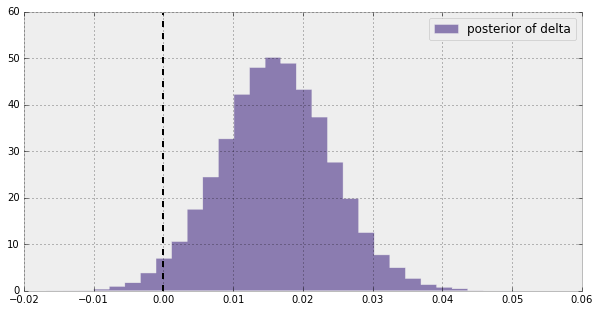

In [6]:
# use .trace to obtain the desired info
delta_samples = mcmc.trace("delta")[:]

plt.figure( figsize = ( 10, 5 ) )
plt.hist( delta_samples, histtype = 'stepfilled', bins = 30, alpha = 0.85,
          label = "posterior of delta", color = "#7A68A6", normed = True )
plt.axvline( x = 0.0, color = "black", linestyle = "--" )
plt.legend(loc = "upper right")
plt.show()

The black line is at x = 0, representing where the difference between the two distributions is 0. From inspection, we see that most of the distribution's mass is to the right of the black line. This means most of the points sampled from B's distribution are larger than those sampled from A's distribution, implying that site B's response is likely better than site A's response. To get more quantitative results, we can compute the probability that website B gets more sign-ups than website A by simply counting the number of samples less than 0, i.e. the area under the curve before 0, 
represent the probability that site B is worse than site A.

In [7]:
print( "Probability site B is WORSE than site A: %.3f"  % ( delta_samples < 0 ).mean() )
print( "Probability site B is BETTER than site A: %.3f" % ( delta_samples > 0 ).mean() )

Probability site B is WORSE than site A: 0.022
Probability site B is BETTER than site A: 0.978


## Diagnosing Convergence

Due to the fact that MCMC is a sampling algorithm, we should also do a double check to make sure that these samples are stable and accurate representatives of the posterior distribution. The current best practice for this is to visually examine **trajectory** and the **autocorrelation**.

The `pymc.Matplot` module contains a poorly named function `plot` and it is preferred to import it as `mcplot` so there is no conflict with `matplotlib`'s plot. The function takes an MCMC's trace object and will return posterior distributions, traces and auto-correlations for each variable.

Plotting delta


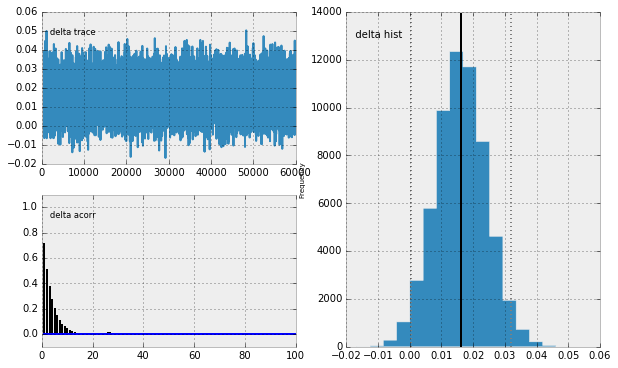

In [8]:
mcplot( mcmc.trace("delta"), common_scale = False )

**Trajectory:** 

The top-left plot, often called the **trace plot** shows the **trajectory** of the samples. If the samples are representative, then they should look like they're zigzagging along the y-axis. Fortunately, our **trace plot** matches the description (The plot will most likely not look like this if you did not specify burn-in samples). 

---

**Autocorrelation:** 

Recall that a good **trace plot** will appear to be zigzagging along the y-axis. This is a sign that tells us the current position will exhibit some sort of correlation with previous positions. And too much of it means we are not exploring the space well.

The bottom-left plot depicts the **autocorrelation**, a measure of how related a series of numbers is with itself. A measurement of 1.0 is perfect positive autocorrelation, 0 no autocorrelation, and -1 is perfect negative correlation.  If you are familiar with standard *correlation*, then autocorrelation is just how correlated a series, $x_\tau$, at time $t$ is with the series at time $t-k$:

$$R(k) = Corr( x_t, x_{t-k} )$$

And there will be a different autocorrelation value for different $k$ (also referred to as lag). For our plot, the autocorrelation value starts to drop near zero for large values of $k$. This is a sign that our random samples are  providing independent information about the posterior distribution, which is exactly what we wanted!!

---

**Posterior Distribution:**

The largest plot on the right-hand side is the histograms of the samples, which is basically the same plot as the ones we manually created, plus a few extra features. The thickest vertical line represents the posterior mean, which is a good summary of posterior distribution. The interval between the two dashed vertical lines in each the posterior distributions represent the 95% credible interval, which can be interpreted as "there is a 95% chance that our parameter of interest lies in this interval".

When communicating your results to others, it is incredibly important to state this interval. One of our purposes for studying Bayesian methods is to have a clear understanding of our uncertainty in unknowns. Combined with the posterior mean, the 95% credible interval provides a reliable interval to communicate the likely location of the unknown (provided by the mean) and the uncertainty (represented by the width of the interval).

---

**Effective Sample Size**

To figure out exactly how many samples we would have to draw, we can compute the **effective sample size (ESS)**, a measure of how many independent samples our our samples are equivalent to. Formally, denote the actual number of steps in the chain as N. The ESS is:

$$ESS = \frac{N}{1 + 2 \sum_{k=1}^\infty ACF(k)}$$

where ACF(k) is the autocorrelation of the series at lag k. For practical computation, the infinite sum in the definition of ESS may be stopped when ACF(k) < 0.05. A rule of thumb for the ESS is that if you wish to have a stable estimates of the 95% credible interval, an ESS around 10,000 is recommended.

In [9]:
def acf( x, lag = 100 ):
    """
    autocorrelation function that calculates the 
    autocorrelation for series x from 1 to the user-specified lag
    
    Parameter
    ---------
    x : 1d-array, size ( iteration - burn-in iteration, )
        pymc's random sample
        
    lag : int, default 100
        maximum lagging number
        
    Return
    ------
    corr : list, size (lag)
        autocorrelation for each lag
    
    Reference
    ---------
    http://stackoverflow.com/questions/643699/how-can-i-use-numpy-correlate-to-do-autocorrelation
    """
    # np.corrcoef here returns a 2 * 2 matrix, either [ 0, 1 ] or [ 1, 0 ]
    # will be the actual autocorrelation between the two series,
    # the diagonal is just the autocorrelation between each series itself
    # which is 1
    corr = [ np.corrcoef( x[k:], x[:-k] )[ 0, 1 ] for k in range( 1, lag ) ]
    return corr


def effective_sample( iteration, burn, corr ):
    """
    calculate the effective sample size of the mcmc,
    note that the calculation is based on the fact that
    the autorrelation plot appears to have converged
    
    Parameters
    ----------
    iteration : int
        number of iteration of the mcmc
    
    burn : int
        burn-in iteration of the mcmc
    
    corr : list
        list that stores the autocorrelation for different lags
    
    Returns
    -------
    the effective sample size : int
    """
    for index, c in enumerate(corr):
        if c < 0.05:
            i = index
            break
    
    return ( iteration - burn ) / ( 1 + 2 * np.sum( corr[:i + 1] ) )

lag = 100
corr = acf( x = delta_samples, lag = lag )
effective_sample( iteration, burn, corr ) # the iteration and burn is specified above

9850.2447707396695

## What's Next?

For these two websites, we see that website B outperforms website A. This worked well for two websites, but if you're modeling an A/B test with several variants ( e.g. an A/B/C/D test ), you should consider using a **hierarchical model** to:

- Protect yourself from a variety of multiple-comparison-type errors.
- Get ahold of posterior distributions for your true conversion rates.

Let's first examine the sort of multiple comparison errors we're trying to avoid. Here's an exaggerated example: 

Suppose that we have a single coin. We flip it 100 times, and it lands heads up on all 100 of them; how likely do you think it is that the coin is fair (i.e has a 50/50 chance of landing heads up)? Pretty slim; The probability of observing 100 heads out of 100 flips of a fair coin is: 

$$1/2^{100} \approx 7.9×10^{−31}$$

Now imagine a new scenario: Instead of just one coin, we now have $2^{100}$ of them. We flip each 100 times. If we noticed that one of the $2^{100}$ coins has landed heads up on all 100 of its flips; how likely do you think it is that this coin is fair? A full answer will lead us into hierarchical modeling, but at this point it's already clear that we need to pay attention to the fact that there were another $2^{100} - 1$ coins: Even if all the $2^{100}$ coins were fair, the probability that at least one of them lands heads up on all 100 flips is:

$$1 − \left( 1 − \frac{1}{2^{100}} \right)^{2^{100}} \approx 1 − \frac{1}{e} \approx 63.2%$$

Back to the website example, if we tried this for all pairs of our five websites, we run the risk of getting a "false positive problem" due to the multiple testing problem. There are 10 possible pairs, so assume we test all possible pairs independently at an alpha = 0.05 level. For each test, we have a 95% chance of not getting a false positive, so the probability that all the tests do not yield a false positive is $0.95^{10}$, which is roughly equal to 0.60. This means the probability of getting at least one false positive result is about 0.40 or 40%. If we had more websites and thus more pairs to test, the probability of getting a false positive would only increase.

As you can see, without correcting for multiple testing, we run a high risk of encountering a false positive result.

## Beta Distribution and Bayesian Priors

Before introducing the Beta-Binomial hierarchical model, let's discuss the theoretical motivation for the Beta distribution. Consider the Uniform Distribution over the interval (0,1).

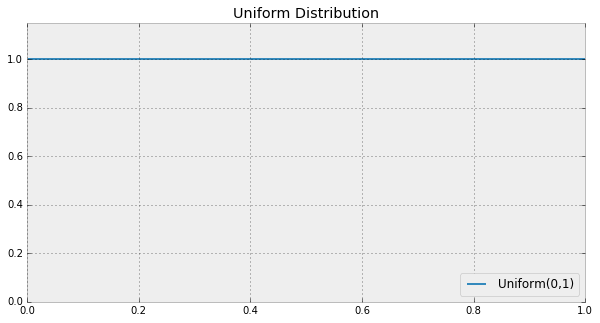

In [10]:
support = np.linspace( 0, 1, num = 500 )
dunif = stats.uniform().pdf(support)

plt.figure( figsize = ( 10, 5 ) )
plt.plot( support, dunif, label = "Uniform(0,1)" )
plt.ylim( 0, 1.15 )
plt.legend( loc = "lower right" )
plt.title("Uniform Distribution")
plt.show()

# replace .show() with .savefig to save the pics and also shows the plot
# plt.savefig( "Uniform.png", format = "png" )

As you can see, it's a simple distribution. It assigns equal probability weight to all points in the domain (0,1), also known as the support of the distribution. However, what if we want a distribution over (0,1) that isn't just flat everywhere?

This is where the Beta distribution comes in! The Beta distribution can be seen as a generalization of the Uniform(0,1) as it allows us to define more general probability density functions over the interval (0,1). Using two parameters a and b, the Beta(a,b) distribution is defined with the following probability density function:

$$pdf(x) = C x^{\alpha - 1} (1 - x)^{\beta - 1}, x \in (0, 1), \alpha, \beta > 0$$

Where C is a constant to normalize the integral of the function to 1 (all probability density functions must integrate to 1). This constant is formally known as the Beta Function.

But the important thing is that by changing the values of a and b, we can change the shape and the "steepness" of the distribution, thus allowing us to easily create a wide variety of functions over the interval (0,1).

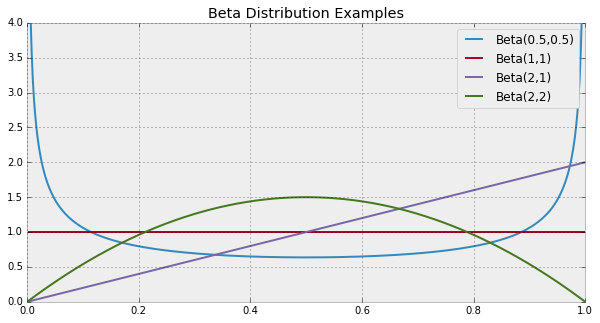

In [11]:
a_vals = ( 0.5, 1, 2, 2 )
b_vals = ( 0.5, 1, 1, 2 )

plt.figure( figsize = ( 10, 5 ) )
for a, b in zip( a_vals, b_vals ):
    plt.plot( support, stats.beta( a, b ).pdf(support), label = "Beta(%s,%s)" % ( a, b ) )
plt.legend()
plt.ylim( 0,4 )
plt.title("Beta Distribution Examples")
plt.show()

Notice in the above plot that the green line corresponding to the distribution Beta(1,1) is the same as that of Uniform(0,1), proving that the Beta distribution is indeed a generalization of the Uniform(0,1).

Now, many of you might be wondering what's the big takeaway from this section, so here they are:

- The Beta Distribution is a versatile family of probability distributions over (0,1). 
- This allows us to create prior distributions that incorporate some of our beliefs and thus informative priors. More concretely, when you have a k-successes-out-of-n-trials-type test, you can use the Beta distribution to model your posterior distributions. If you have test with k success amongst n trials, your posterior distribution is $Beta(k+1,n−k+1)$.

In the next section, we will discuss why this is important, and how the Beta Distribution can be used for A/B testing.

## Hierarchical Models

**Hierarchical models** are models that involves multiple parameters such that the credible values of some parameters depend on the values of other parameters. Thus **Hierarchical models** will model all of the test buckets at once, rather than treating each in isolation. More specifically, they use the observed rates of each bucket to infer a prior distribution for the true rates; these priors then influences the predicted rates by "shrinking" posterior distributions towards the prior.

Let's work our way up to this idea. First, let's say that we flip a coin 100 times and that it lands heads-up on 60 of them. We can then model this as $p \sim Beta(61,41)$, and our posterior distribution looks like this:

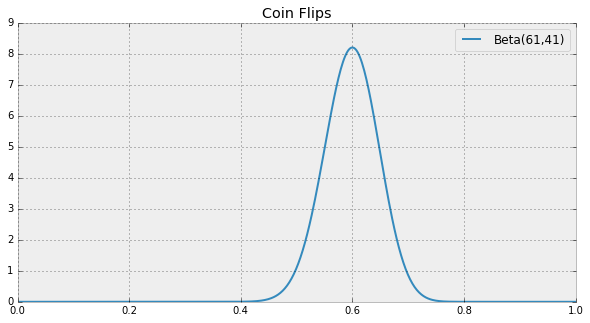

In [12]:
plt.figure( figsize = ( 10, 5 ) )
plt.plot( support, stats.beta( 61, 41 ).pdf(support), label = "Beta(%s,%s)" % ( 61, 41 ) )
plt.legend()
plt.title("Coin Flips")
plt.show()

Side note on a handy general rule. The intuition behind $Binomial(n,p)$ is that if we flip a coin with probability p of landing heads n times, how likely is it that we see k heads for some k between 0 and n.

And given that information, If your prior is $p \sim Beta(a,b)$ and you observe $X=k$ for $X \sim Binomial(n,p)$, then your posterior is $(p∣X) \sim Beta(a+k,b+n−k)$. Beta is a "conjugate prior" for the Binomial, meaning that the posterior is also Beta.

Second, let's suppose, unrealistically, that we have an explicit prior distribution. We've flipped a lot of similar coins in the past, and we're pretty sure that the true bias of such coins follows a $Beta(51,51)$ distribution. Applying Bayes' rule with this prior, we would now model our observation of 60 out of 100 heads-up as $p \sim Beta(112,92)$. 

Now our posterior distribution looks as follows. We keep the original for reference:

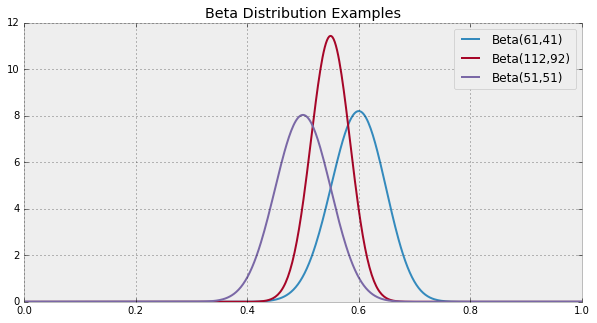

In [13]:
a_vals = ( 61, 112, 51 )
b_vals = ( 41, 92, 51 )

plt.figure( figsize = ( 10, 5 ) )
for a, b in zip( a_vals, b_vals ):
    plt.plot( support, stats.beta( a, b ).pdf(support), label = "Beta(%s,%s)" % ( a, b ) )
plt.legend()
plt.title("Beta Distribution Examples")
plt.show()

Notice how much the distribution has shifted to the towards the prior! The preceding plot tells us that when we know an explicit prior, we should use it. Great. The problem with all of this is that for A/B tests, we often don't have an explicit prior. But when we have multiple test buckets, we can infer a prior. 

To keep things concrete, let's say that we are designing a company's website, and we're testing five different layouts for the landing page. When a user clicks on our site, he/she sees one of the five landing page layouts. From there, the user can decide whether or not she wants to create an account on the site.

| Experiment | Clicks | Orders | True Rate  | Empirical Rate |
|------------|--------|--------|------------|----------------|
|      A     | 1055   | 28     | 0.032      | 0.027          |
|      B     | 1057   | 45     | 0.041      | 0.043          |
|      C     | 1065   | 69     | 0.058      | 0.065          |
|      D     | 1039   | 58     | 0.047      | 0.056          |
|      E     | 1046   | 60     | 0.051      | 0.057          |

As a disclaimer, this is simulated data that is created to mimic a real A/B testing data. The number of Orders for each website was generated by generating a number from a Binomial distribution with n = Clicks and p = True Rate. The Empirical Rate represents the actual or so called observed Orders/Clicks

So now we have $\beta_1, ...,\beta_5$ tests and that for each test $\beta_i$ we observe $k_i$ successes out of $N$ trials. Let's further say that each bucket $\beta_i$ has some true success rate $p_i$; we don't know what $p_i$ is, but we're assuming that $k_i$ was drawn from a $Binomial( N, p_i )$ distribution. What we'd like is a prior for each $p_i$. The key idea is: Let's assume that all the $p_i$ are drawn from the same distribution, and let's use the empirically observed rates, i.e. the $k_i$s to infer what this distribution is.

Here's what the whole setup looks like. We assume that our sign-ups $k_i$ is modeled as $k_i \sim Binomial(100, p_i)$. We then assume that every $p_i$, the true sign-up rates for each website is drawn from the same $Beta(a,b)$ distribution for some parameters a and b; briefly, $p_i \sim Beta(a,b)$. We don't have any prior beliefs for a and b, so we'd like them to be drawn from an "uninformative prior". 

Recall that in the *Bernoulli Method* section, when we had no prior information about the true rates for each website we used an uniform distribution as our "uninformative prior". In this section, we will assume each true sign-ups rate is drawn from a Beta distribution.

Now, we've neglected one important question up until this point, How do we choose the a and b for the Beta distribution? Well, maybe we could assign a prior distribution to choose these hyper-parameters, but then our prior distribution has a prior distribution and it's priors all the way down.... A better alternative is to sample a and b from the distribution:

$$p(a, b) \propto \frac{1}{(a+b)^{5/2}}$$

Where $\propto$ represents is proportional to. This may look like magic, but let's just assume that this is correct that keep going. Now that we've covered the theory, we can finally build our hierarchical model. The beta priors function samples a and b for us from the function defined above. 

Using the pymc module, we use the `@pm.stochastic` decorator to define a custom prior for a parameter in a model, since the decorator requires that we return the log-likelihood, so we will be returning the log of $(a+b)^{-2.5}$.

In [14]:
@pm.stochastic( dtype = np.float64 )
def beta_priors( value = [ 1.0, 1.0 ] ):  
    a, b = value
    # outside of the support of the distribution
    if a <= 0 or b <= 0:
        return -np.inf
    else:
        return np.log( np.power( ( a + b ), -2.5 ) )

a = beta_priors[0]
b = beta_priors[1]

We then model the true sign-up rates as Beta distribution and use our observed sign-up data to construct the Binomial distribution. Once again use MCMC to sample the data points and throw out the first few.

In [15]:
# The hidden, true rate for each website, or simply
# this is what we don't know, but would like to find out
true_rates = pm.Beta( 'true_rates', a, b, size = 5 )

# The observed values, clicks and orders
trials = np.array([ 1055, 1057, 1065, 1039, 1046 ])  
successes = np.array([ 28, 45, 69, 58, 60 ])  
observed_values = pm.Binomial( 'observed_values', trials, true_rates, 
                               value = successes, observed = True )

model1 = pm.Model([ a, b, true_rates, observed_values ])  
mcmc1  = pm.MCMC(model1)
pm.MAP(model1).fit()
iteration1 = 70000
burn1 = 10000
mcmc1.sample( iteration1, burn1 )  

 [-----------------100%-----------------] 70000 of 70000 complete in 8.0 sec

Let's see what our five posterior distributions look like.

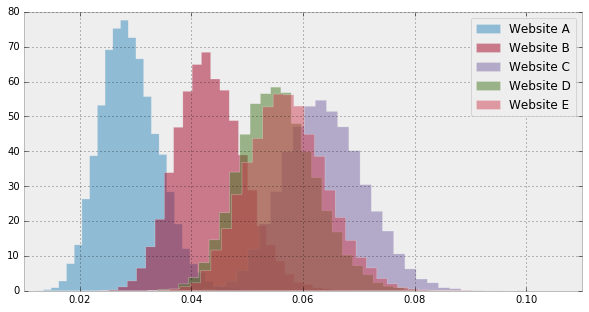

In [16]:
traces = mcmc1.trace('true_rates')[:]

plt.figure( figsize = ( 10, 5 ) )
for i in range(5):
    # our true rates was a size of 5, thus each column represents each true rate
    plt.hist( traces[ :, i ], 
              histtype = 'stepfilled', bins = 30, alpha = 0.5,
              label = "Website %s" % chr( 65 + i ), normed = True )

plt.legend(loc = "upper right")
plt.show()

Now that we have all five posterior distributions, we can easily computer the difference between any two of them. For example, let's revisit the difference of the posterior distribution of website B and website A.

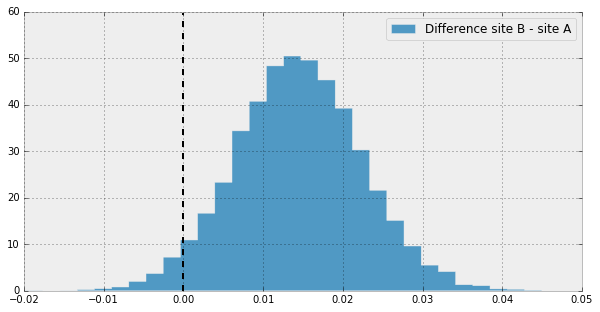

In [17]:
diff_BA = traces[ :, 1 ] - traces[ :, 0 ]

plt.figure( figsize = ( 10, 5 ) )
plt.hist( diff_BA, histtype = 'stepfilled', bins = 30, alpha = 0.85,
          label = "Difference site B - site A", normed = True )
plt.axvline( x = 0.0, color = "black", linestyle = "--" )
plt.legend(loc = "upper right")
plt.show()

we see most of the probability mass of this posterior distribution lies to the right of the line x = 0.00. We can quantify these results using the same method we used for the difference between website C and website A.

In [18]:
print( "Prob. that website A gets MORE sign-ups than website C: %0.3f" % (diff_BA < 0).mean() )
print( "Prob. that website A gets LESS sign-ups than website C: %0.3f" % (diff_BA > 0).mean() )

Prob. that website A gets MORE sign-ups than website C: 0.035
Prob. that website A gets LESS sign-ups than website C: 0.965


Again, we see results showing that website B has a higher sign-up rate than website A at a statistically significant level, same as the result when using the Bernoulli model.

Though it should be noted that It the hierarchical model cannot overcome the limitations of data. For example, let's consider website D and website E. While these two websites have a differing true sign-up rate (website E being better than website D), they have virtually identical click and sign-up data. As a result, our difference of the posterior yields a distribution centered about 0.0 (see plot below), and we cannot conclude that one website has a higher sign-up rate at a statistically significant level.

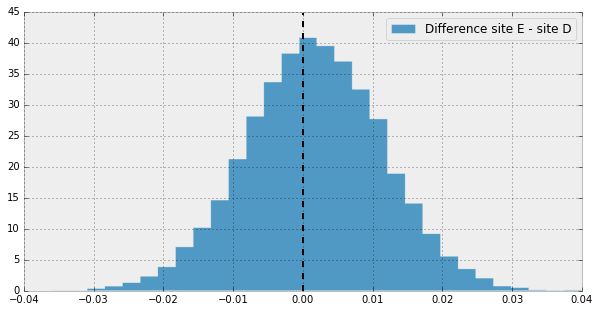

Probability that website D gets MORE sign-ups than website E: 0.433
Probability that website D gets LESS sign-ups than website E: 0.567


In [19]:
diff_ED = traces[ :, 4 ] - traces[ :, 3 ]

plt.figure( figsize = ( 10, 5 ) )
plt.hist( diff_ED, histtype = 'stepfilled', bins = 30, alpha = 0.85,
          label = "Difference site E - site D", normed = True )
plt.axvline( x = 0.0, color = "black", linestyle = "--" )
plt.legend(loc = "upper right")
plt.show()

print( "Probability that website D gets MORE sign-ups than website E: %0.3f" % (diff_ED < 0).mean() )
print( "Probability that website D gets LESS sign-ups than website E: %0.3f" % (diff_ED > 0).mean() )

## Comparing the Two Methods

We have gone through two different ways to do A/B testing: One way using Bernoulli distributions, and another using Beta-Binomial distributions. The Beta-Binomial hierarchical model is motivated by using the problem of multiple comparison testing. Let's now compare the performance of the two methods by examining the posterior distribution generated for Website A by each of the two methods. A black vertical line at x = 0.032, the true rate is included.

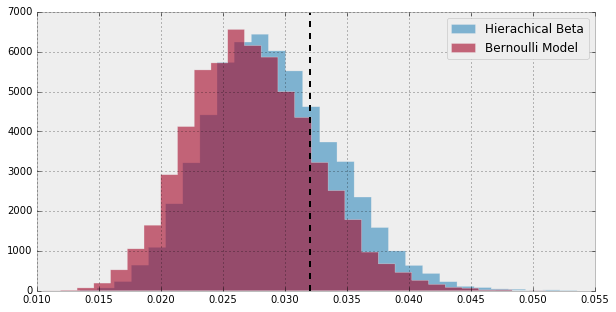

In [20]:
# trace of the bernoulli way
siteA_distribution = mcmc.trace("p_A")[:]

plt.figure( figsize = ( 10, 5 ) )
plt.hist( traces[ :, 0 ], histtype = 'stepfilled', bins = 30, alpha = 0.6,
          label = "Hierachical Beta" )
plt.hist( siteA_distribution, histtype = 'stepfilled', bins = 30, alpha = 0.6,
          label = "Bernoulli Model" )
plt.axvline( x = 0.032, color = "black", linestyle = "--" )
plt.legend(loc = "upper right")
plt.show()

In this case, the mass of the **Hierarchical Beta-Binomial** model is closer to the true rate than that of the Bernoulli model. The posteriors of the hierarchical model gave us a closer estimate of the true rate.

Why does the Hierarchical Beta-Binomial model appear to be more accurate in estimating the true rate? Well this comes down to the prior distributions used in each method. In the classical Bernoulli method, we used the $Uniform(0,1)$ as our prior distribution. As I mentioned earlier, this is an uninformative prior as it assigns equal weight to all possible probabilities. On the other hand, the Beta prior creates a distribution that puts some of the probability mass towards the "truth" and thus we see a more a bit accurate estimate for the posterior distribution.

The other thing worth noticing is that remember Website A was observed to have a success rate of 0.027% and a true (unobserved) success rate of 0.032%. And our **Hierarchical Beta-Binomial**'s posterior distribution's estimation was about:

In [21]:
# true rate : 0.032
# empirical rate : 0.027
# Hierarchical Beta-Binomial posterior's true rate
traces[ :, 0 ].mean()

0.029003580707517365

As we can see directly, that the hierarchical model gives a much better estimate than the empirical rate. Again, this is because hierarchical models shrink the individual posteriors towards the family-wise posterior. (You can think of it as "regression to the mean" in a special case.)

Plotting true_rates_0
Plotting true_rates_1
Plotting true_rates_2
Plotting true_rates_3
Plotting true_rates_4


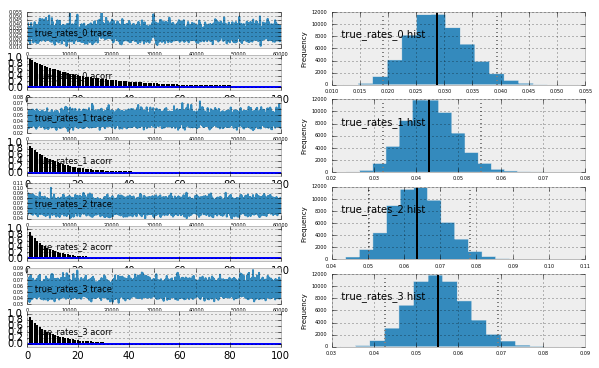

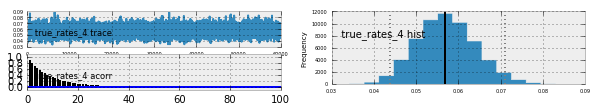

In [22]:
# we can also plot the diagnosis that checks for convergence like we did above
mcplot( mcmc1.trace("true_rates"), common_scale = False )

## Some Thoughts

Bayesian modeling is sometimes met with suspicion because of the imposition of a prior distribution. The objection is that in the context of a novel A/B test, we don't have any grounds to assume a prior distribution. Who knows how the test will perform? We've never tested something like this before.

The beauty of the hierarchical model outlined above is that it doesn't force you to assume an explicit prior distribution; it merely assumes that the distribution prior comes from a certain family of distributions (namely, Beta), and then infers a distribution for possible priors based on your data.

Here are a couple of thought experiments that give an intuitive justification for hierarchical modeling.

- One should realize that you always assume a prior distribution when conducting Bayesian modeling; it cannot be avoided. If in the example above, if you were to model each test independently, i.e. Website A as $Beta( 28 + 1, 1055 - 28 + 1 )$, Website B as $Beta( 45 + 1, 1057 - 45 + 1)$, etc., you would be assuming a uniform prior for each bucket's true rate. That's a pretty unrealistic prior to assume; Do we really believe that a true rate of 60% is just as likely as a true rate of 30%? No, but that's exactly what assuming a uniform prior implies. You have to assume a prior; the goal is to choose the best one possible.
- It's reasonable to believe that knowing the observed success rate of one website should influence your estimation of other websites' success rates. Imagine that we're testing button colors, and we try out 5 variants. The results just came in, but neither of us has looked at them yet. I propose that we play a game. I'll randomly select 4 out of the 5 tests, and tell you how many conversions they achieved out of the exposures that each tests had. You then guess the number of conversions that the 5th test achieved; if you're wrong, you pay me 100, and if you're right, I pay you 10,000. The results come in. We play the game. I tell you that of the 4 buckets I randomly selected, all of them achieved between 30 and 60 percent conversions. What are you going to guess? Are you really indifferent between guessing 50 and guessing 100? Of course not; you're going to guess something between 30 and 60, and you stand a decent chance of taking my money. Knowing about the other tests tells you something about the 5th.

## Conclusion

Data scientist use A/B testing to make meaningful impacts in their company's performance. Good A/B testing can lead to million-dollar results, but good A/B testing is also more complicated than you would think. There are many pitfalls that can lead to meaningless results.

Bayesian Hierarchical models provide an easy method for A/B testing that overcomes some of these pitfalls that plague data scientist. Having the full set of posterior distributions gives you a lot of flexibility in making more complicated inferences. Suppose you wanted to know just how much better test A's success rate is higher than B's. No problem; you know the posterior distributions of  and A and B, so you know the posterior distribution for A - B, and you can easily compute, e.g. whether $p(A-B \geq 0.05)$. Also from a few examples above, we know that interpreting the results is quite easy.

## Reference

- [Blog: Stastical Advice for A/B Testing](http://sl8r000.github.io/ab_testing_statistics/)
- [Notebook: Bayesian Statistics for Hackers Chapter 2](http://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter2_MorePyMC/Ch2_MorePyMC_PyMC2.ipynb)
- [Blog: A/B Testing with Hierarchical Models in Python](http://blog.dominodatalab.com/ab-testing-with-hierarchical-models-in-python/)